In [1]:
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from utils import definitions as defs
from utils import visualization as viz

In [2]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

In [3]:
df = pd.read_excel(defs.ETLED_DATA_PATH)

## Предобработка

Кодируем бинарные признаки.

In [4]:
for feature in defs.BINARY_FEATURES:
    if  df[feature].isna().sum():
        df[feature].replace({np.NaN: -1}, inplace=True)
    df[feature].replace({defs.YES: 1, defs.NO: 0}, inplace=True)

Кодируем категориальные признаки.

In [5]:
df.replace({
    defs.QUESTION_3:
    {
        defs.ANSWER_3_1: 0,
        defs.ANSWER_3_2: 1,
        defs.ANSWER_3_3: 2,
        defs.ANSWER_3_4: 3,
        defs.ANSWER_3_5: 4,
    },
    defs.QUESTION_5:
    {
        np.NaN: -1,
        defs.ANSWER_5_5: 0,
        defs.ANSWER_5_4: 1,
        defs.ANSWER_5_3: 2,
        defs.ANSWER_5_2: 3,
        defs.ANSWER_5_1: 4,
    },
    defs.QUESTION_7:
    {
        np.NaN: -1,
        defs.ANSWER_7_6: 0,
        defs.ANSWER_7_5: 1,
        defs.ANSWER_7_4: 2,
        defs.ANSWER_7_3: 3,
        defs.ANSWER_7_2: 4,
        defs.ANSWER_7_1: 5,
    },
    defs.QUESTION_9:
    {
        np.NaN: -1,
    },
    defs.QUESTION_11:
    {
        np.NaN: -1,
        defs.ANSWER_11_6: 0,
        defs.ANSWER_11_5: 1,
        defs.ANSWER_11_4: 2,
        defs.ANSWER_11_3: 3,
        defs.ANSWER_11_2: 4,
        defs.ANSWER_11_1: 5,
    },
    defs.QUESTION_12:
    {
        np.NaN: -1,
        defs.ANSWER_12_1: 0,
        defs.ANSWER_12_2: 1,
        defs.ANSWER_12_3: 2,
        defs.ANSWER_12_4: 3,
    },
    defs.QUESTION_13:
    {
        np.NaN: -1,
        defs.ANSWER_13_7: 0,
        defs.ANSWER_13_6: 1,
        defs.ANSWER_13_5: 2,
        defs.ANSWER_13_4: 3,
        defs.ANSWER_13_3: 4,
        defs.ANSWER_13_2: 5,
        defs.ANSWER_13_1: 6,
    },
    defs.QUESTION_14:
    {
        np.NaN: -1,
        defs.ANSWER_14_4: 0,
        defs.ANSWER_14_3: 1,
        defs.ANSWER_14_2: 2,
        defs.ANSWER_14_1: 3,
    },
    defs.QUESTION_16:
    {
        np.NaN: -1,
    },
    defs.QUESTION_17:
    {
        np.NaN: -1,
    },
    defs.QUESTION_18:
    {
        np.NaN: -1,
    },
    defs.QUESTION_19:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    },
    defs.QUESTION_20:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    },
    defs.QUESTION_23:
    {
        np.NaN: -1,
        defs.ANSWER_23_1: 0,
        defs.ANSWER_23_2: 1,
        defs.ANSWER_23_3: 2,
    },
    defs.QUESTION_25:
    {
        np.NaN: -1,
        defs.ANSWER_25_1: 0,
        defs.ANSWER_25_2: 1,
        defs.ANSWER_25_3: 2,
    },
    defs.QUESTION_26:
    {
        np.NaN: -1,
        defs.ANSWER_26_1: 0,
        defs.ANSWER_26_2: 1,
        defs.ANSWER_26_3: 2,
    },
    defs.QUESTION_27:
    {
        np.NaN: -1,
        defs.ANSWER_27_4: 0,
        defs.ANSWER_27_3: 1,
        defs.ANSWER_27_2: 2,
        defs.ANSWER_27_1: 3,
    },
    defs.QUESTION_28:
    {
        np.NaN: -1,
        defs.ANSWER_28_4: 0,
        defs.ANSWER_28_3: 1,
        defs.ANSWER_28_2: 2,
        defs.ANSWER_28_1: 3,
    },
    defs.QUESTION_29:
    {
        np.NaN: -1,
        defs.ANSWER_29_4: 0,
        defs.ANSWER_29_3: 1,
        defs.ANSWER_29_2: 2,
        defs.ANSWER_29_1: 3,
    },
}, inplace=True)

df[defs.QUESTION_9] = df[defs.QUESTION_9].astype('int64')
df[defs.QUESTION_16] = df[defs.QUESTION_16].astype('int64')
df[defs.QUESTION_17] = df[defs.QUESTION_17].astype('int64')
df[defs.QUESTION_18] = df[defs.QUESTION_18].astype('int64')

In [6]:
Y = df[defs.TARGET]
X = df.drop(defs.TARGET, axis=1)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)

In [8]:
model = CatBoostClassifier(
    cat_features=list(defs.CATEGORICAL_FEATURES)+list(defs.RANK_FEATURES)+list(defs.BINARY_FEATURES),
    random_seed=RANDOM_STATE,
)
model.fit(
    X_train, Y_train,
    verbose=False,
)
model.save_model(defs.CATBOOST)

In [9]:
Y_pred = model.predict(X_test)

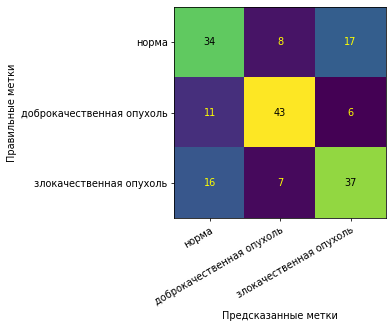

In [10]:
cm = viz.get_confusion_matrix(Y_test, Y_pred, defs.LABELS, defs.LABELS)
viz.plot_confusion_matrix(cm, defs.LABELS, defs.LABELS)

In [11]:
print(classification_report(Y_test, Y_pred))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.74      0.72      0.73        60
  злокачественная опухоль       0.62      0.62      0.62        60
                    норма       0.56      0.58      0.57        59

                 accuracy                           0.64       179
                macro avg       0.64      0.64      0.64       179
             weighted avg       0.64      0.64      0.64       179



## PredictionValuesChange

In [12]:
PredictionValuesChange = model.get_feature_importance()

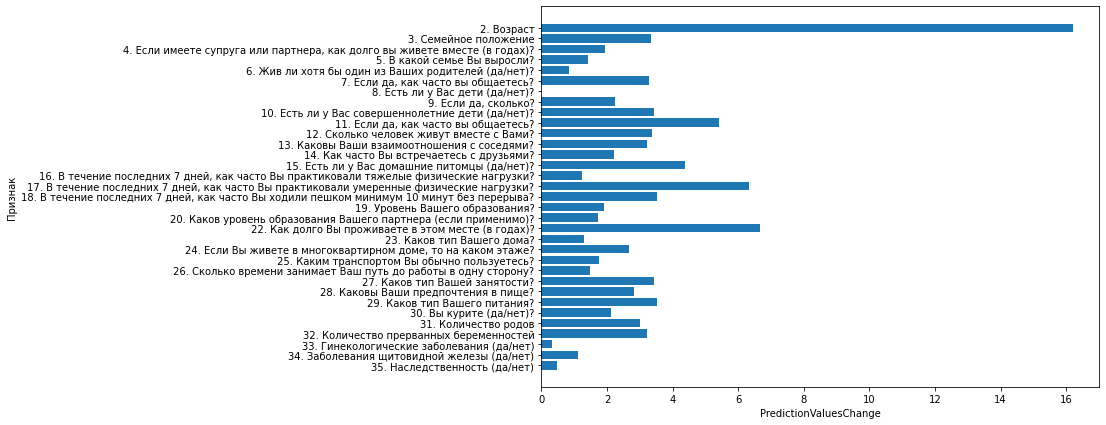

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(list(reversed(defs.FEATURES)), list(reversed(PredictionValuesChange)), align='center')
ax.set_xlabel('PredictionValuesChange')
ax.set_ylabel('Признак')

plt.show()

## SHAP values

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

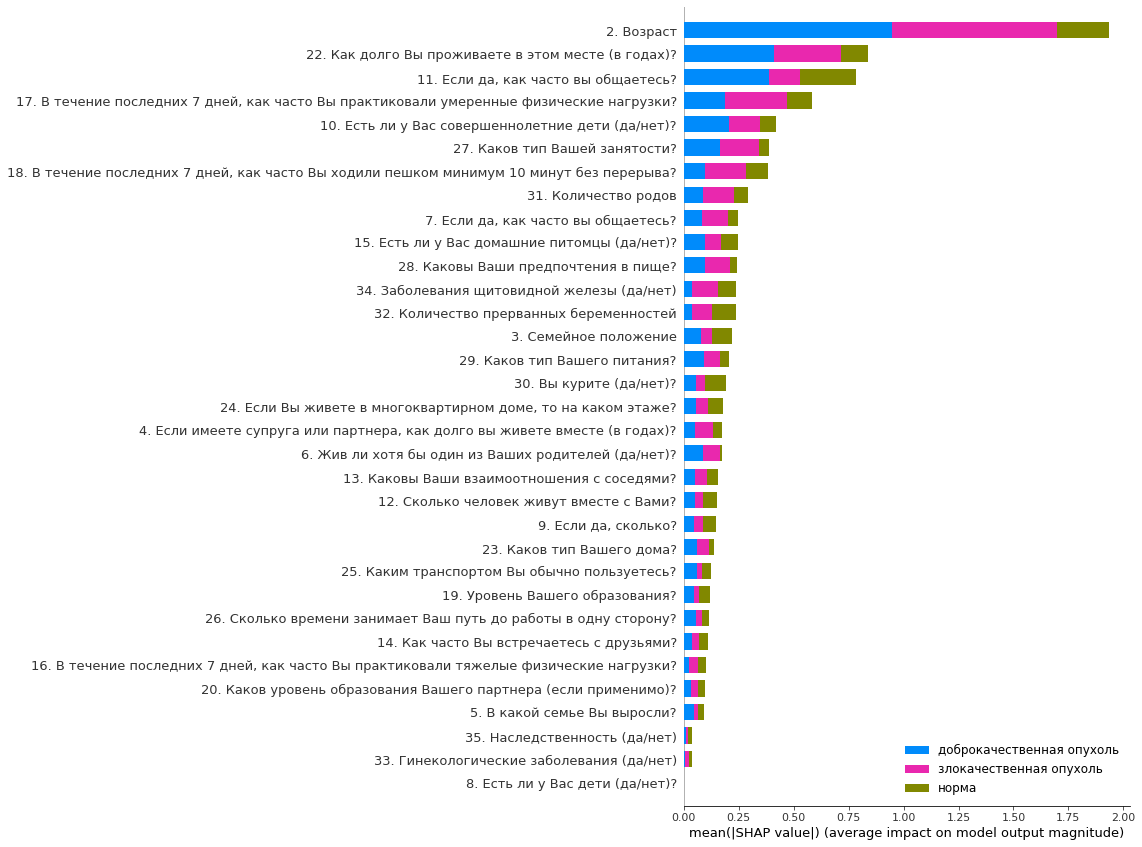

In [15]:
shap.summary_plot(shap_values, X, max_display=33, class_names=list(sorted(defs.LABELS)))

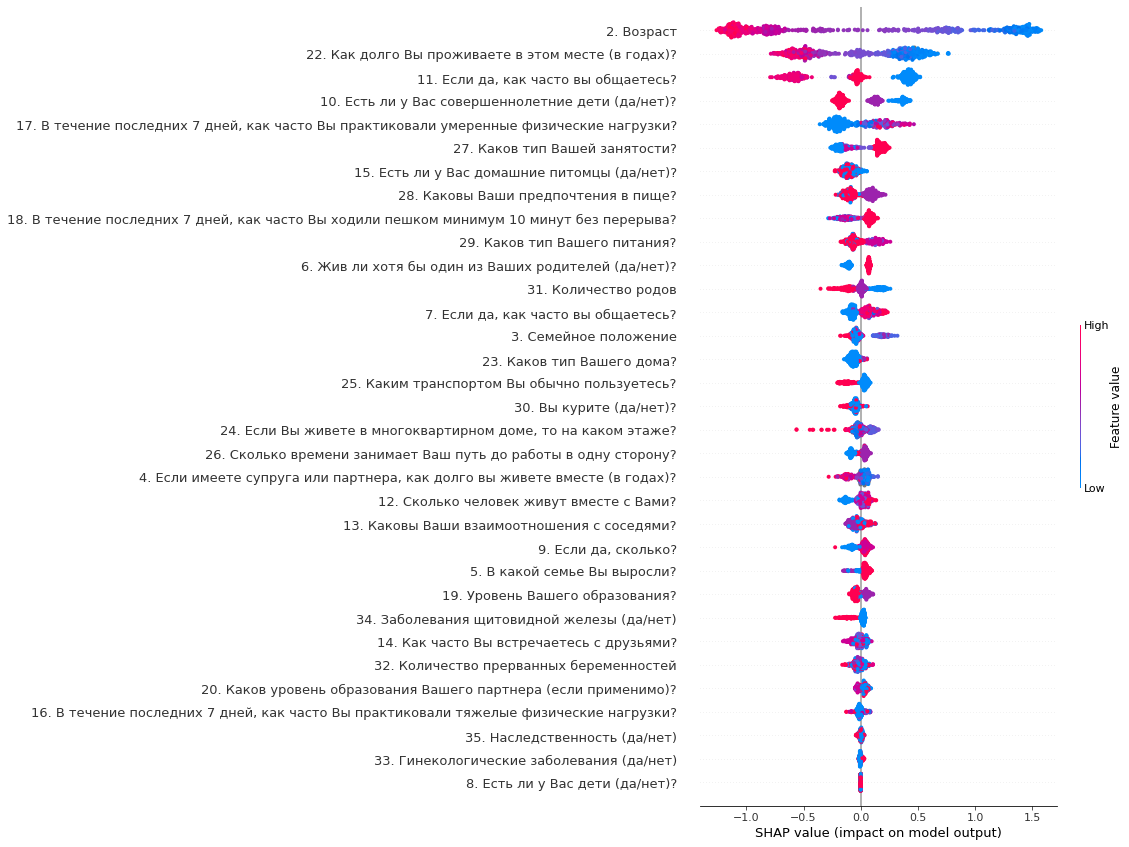

In [16]:
shap.summary_plot(shap_values[0], X, max_display=33)

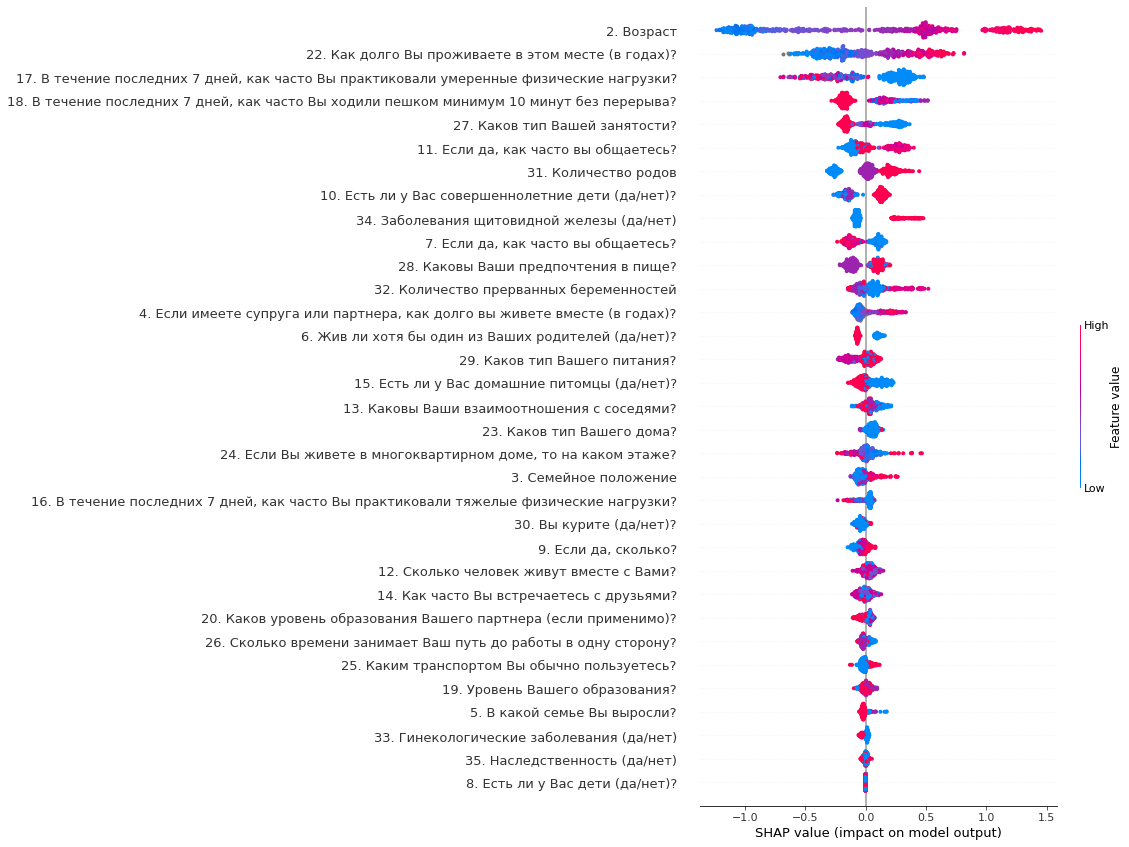

In [17]:
shap.summary_plot(shap_values[1], X, max_display=33)

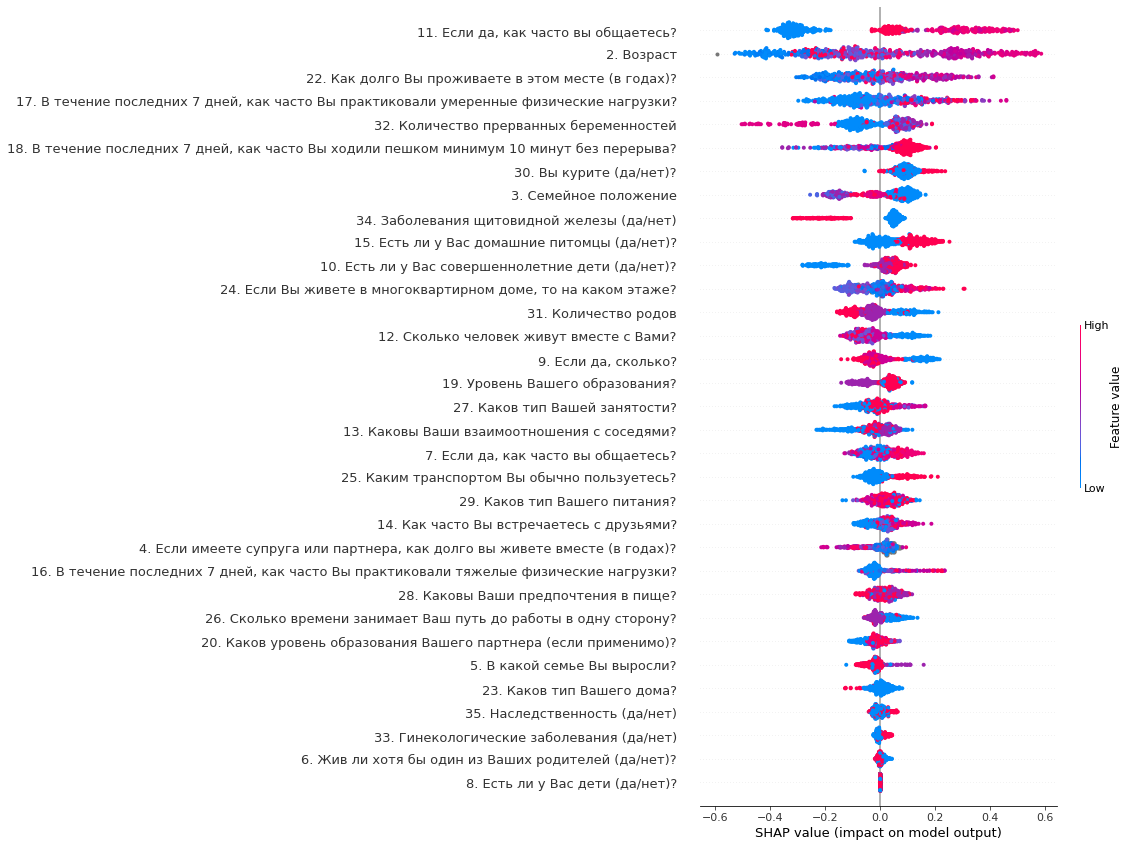

In [18]:
shap.summary_plot(shap_values[2], X, max_display=33)

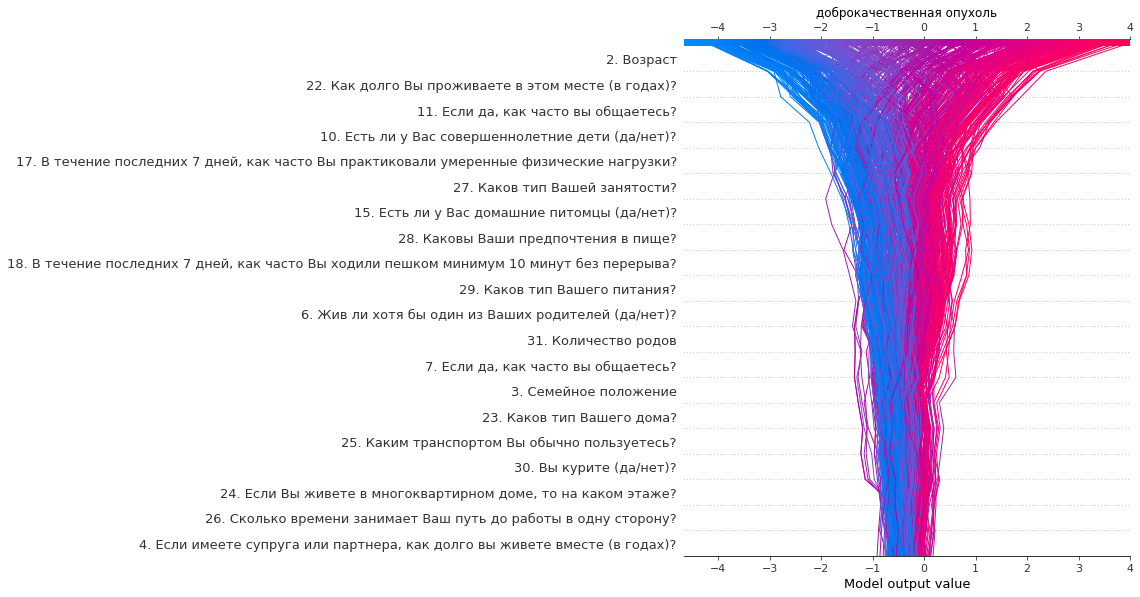

In [19]:
shap.decision_plot(
    expected_value[0],
    shap_values[0],
    defs.FEATURES,
    title=list(sorted(defs.LABELS))[0],
)

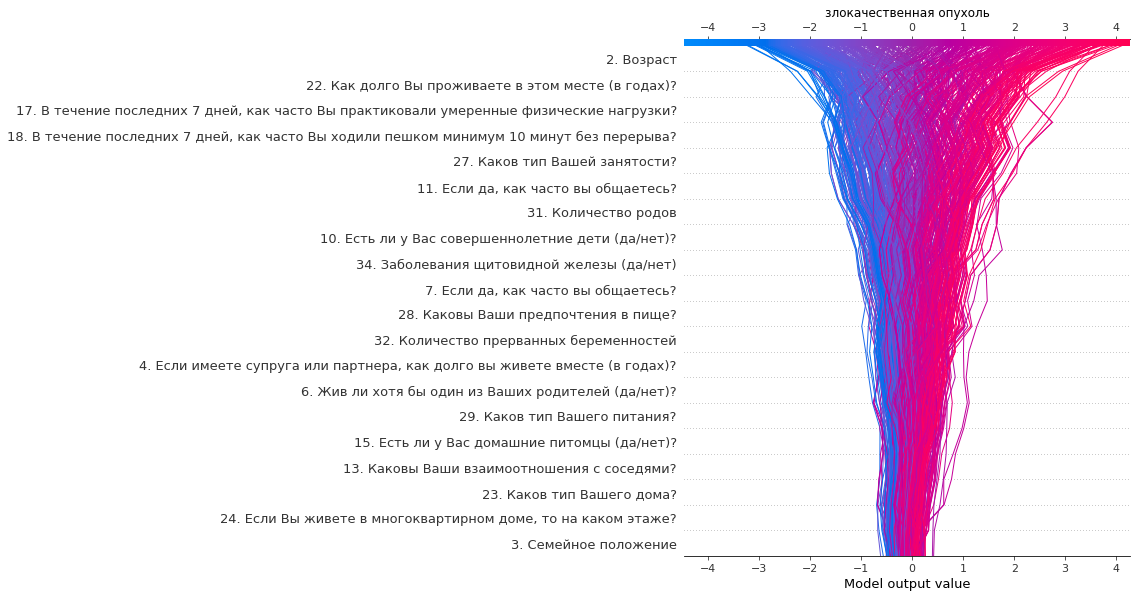

In [20]:
shap.decision_plot(
    expected_value[1],
    shap_values[1],
    defs.FEATURES,
    title=list(sorted(defs.LABELS))[1],
)

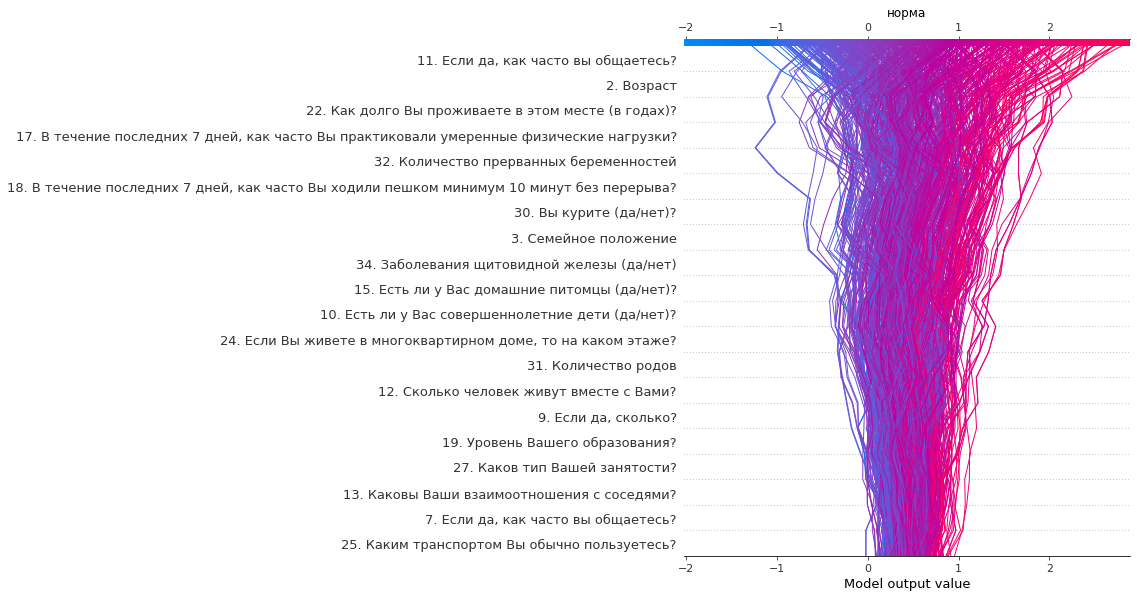

In [21]:
shap.decision_plot(
    expected_value[2],
    shap_values[2],
    defs.FEATURES,
    title=list(sorted(defs.LABELS))[2],
)